In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout, BatchNormalization, Add, Activation, Input, GlobalAveragePooling2D
from keras.activations import relu, softmax
from keras.regularizers import l2
from keras import optimizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 1)


In [0]:
#x_trainN1 = (x_train - 127.5) / 255.0
x_trainN1 = x_train - x_train.mean(axis=0)
#x_trainN1 = x_trainN1 / np.sqrt((x_trainN1 ** 2).sum(axis=1))[:,None]
x_trainN1 = x_trainN1 / np.std(x_trainN1)
print(x_trainN1.mean(), np.std(x_trainN1))
y_trainN1  = keras.utils.to_categorical(y_train, num_classes=10)

-9.059419880941278e-18 0.9999999999999999


In [0]:
#x_testN1 = (x_test - 127.5) / 255.0
x_testN1 = (x_test - x_test.mean()) / np.std(x_testN1)
print(x_testN1.mean(), np.std(x_testN1))
#x_testN1 = x_testN1 / np.sqrt((x_train ** 2).sum(axis=1))[:,None]
y_testN1  = keras.utils.to_categorical(y_test, num_classes=10)

-8.969121741605097e-17 1.0000000000000009


In [0]:
x_trainN1, x_validN1, y_trainN1, y_validN1 = train_test_split(x_trainN1, y_trainN1, test_size=0.1, shuffle=True, random_state=42)

In [0]:
print(x_trainN1.shape, x_validN1.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


In [0]:
def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Valid'], loc='upper right')
  plt.show()

In [0]:
def ResidLayer(input, filters, strides=(1,1), n=3, bm=0.99, l2val=1e-4):
    X = Conv2D(filters,
               (3,3), 
               strides=strides, 
               padding="same", 
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(input)
    X = BatchNormalization(momentum=bm)(X)
    X = Activation('relu')(X)

    if strides != (1,1):
        shortcut = Conv2D(filters, 
                          (1,1), 
                          strides=(2,2), 
                          padding="same",
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(l2val))(input)
        shortcut = BatchNormalization(momentum=bm)(shortcut)

    for _ in range(n-2):
        X = Conv2D(filters, 
                   (3,3), strides=(1,1), 
                   padding="same",
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(l2val))(X)
        X = BatchNormalization(momentum=bm)(X)
        X = Activation('relu')(X)

    X = Conv2D(filters, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X)
    X = BatchNormalization(momentum=bm)(X)

    #if strides != (1,1):
    #    input = ZeroPadding2D(padding=strides)
    if strides != (1,1):
      X = Add()([X, shortcut])
    else:
      X = Add()([X, input])
    output = Activation('relu')(X)
    return output



In [0]:
def ResNet(input_shape=(32, 32, 3), classes=10, n=3, batchnorm_momentum=0.99, l2val=1e-4):
    X_input = Input(input_shape)
    X = Conv2D(16, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X_input)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = Activation('relu')(X)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 64, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 64, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Dense(classes, activation=softmax)(X)

    return Model(inputs=X_input, output=X, name='ResNet')


In [0]:
model = ResNet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


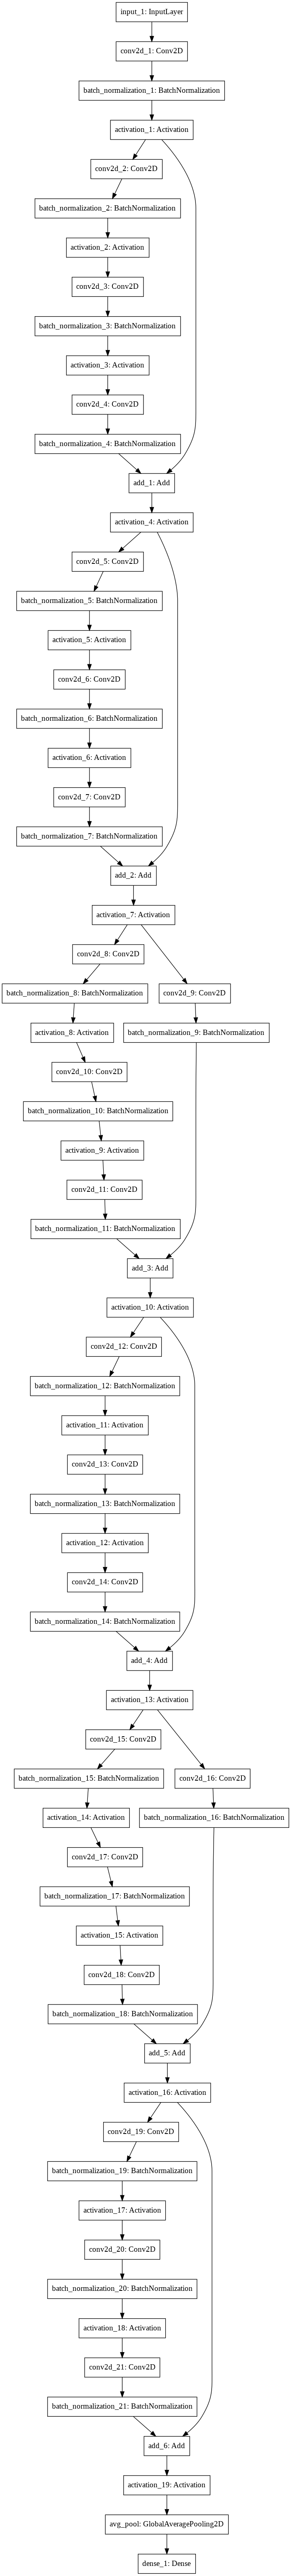

In [0]:
from keras.utils import plot_model
plot_model(model)

In [0]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_____________________________________________________________________________________________

In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 50:
      return 0.001
  if epoch > 30:
      return 0.005
  if epoch > 20:
      return 0.01
  if epoch > 10:
      return 0.05
  return 0.1

lrscheduler = LearningRateScheduler(lfScheduleF, verbose=0)

## Different learning strategy


In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 40:
      return 0.005
  if epoch > 30:
      return 0.01
  if epoch > 15:
      return 0.05
  return 0.1

lrscheduler = LearningRateScheduler(lfScheduleF, verbose=0)

## ResNet with dropout

In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 75:
      return 0.005
  if epoch > 50:
      return 0.01
  if epoch > 25:
      return 0.05
  return 0.1

lrscheduler = LearningRateScheduler(lfScheduleF, verbose=0)

In [0]:
def ResNetDropout(input_shape=(32, 32, 3), classes=10, n=3, batchnorm_momentum=0.99, l2val=1e-4):
    X_input = Input(input_shape)
    X = Conv2D(16, 
               (3,3), 
               strides=(1,1), 
               padding="same",
               kernel_initializer='he_normal',
               kernel_regularizer=l2(l2val))(X_input)
    X = BatchNormalization(momentum=batchnorm_momentum)(X)
    X = Activation('relu')(X)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 16, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = ResidLayer(X, 32, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = Dropout(0.2)(X)
    X = ResidLayer(X, 64, strides=(2,2), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = Dropout(0.2)(X)
    X = ResidLayer(X, 64, strides=(1,1), n=n, bm=batchnorm_momentum,l2val=l2val)
    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Dense(100, activation=relu)(X)
    X = Dense(classes, activation=softmax)(X)

    return Model(inputs=X_input, output=X, name='ResNetDropout')


## With data augmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Epoch 1/50
352/352 [==============================] - 36s 102ms/step - loss: 1.6599 - accuracy: 0.4530 - val_loss: 3.5288 - val_accuracy: 0.3040
Epoch 2/50
352/352 [==============================] - 32s 90ms/step - loss: 1.2123 - accuracy: 0.6256 - val_loss: 2.0559 - val_accuracy: 0.4630
Epoch 3/50
352/352 [==============================] - 32s 90ms/step - loss: 1.0343 - accuracy: 0.6926 - val_loss: 1.3915 - val_accuracy: 0.6106
Epoch 4/50
352/352 [==============================] - 32s 90ms/step - loss: 0.9190 - accuracy: 0.7384 - val_loss: 1.0199 - val_accuracy: 0.7024
Epoch 5/50
352/352 [==============================] - 32s 90ms/step - loss: 0.8482 - accuracy: 0.7655 - val_loss: 1.3101 - val_accuracy: 0.6206
Epoch 6/50
352/352 [==============================] - 32s 90ms/step - loss: 0.7962 - accuracy: 0.7843 - val_loss: 1.0005 - val_accuracy: 0.7118
Epoch 7/50
352/352 [==============================] - 32s 90ms/step - loss: 0.7523 - accuracy: 0.8001 - val_loss: 1.0936 - val_accuracy

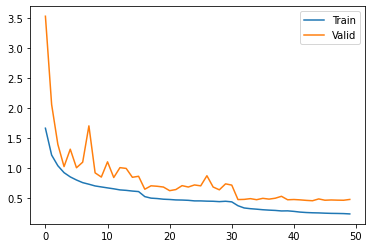

5000/5000 [==============================] - 1s 219us/step
[0.47187461969852446, 0.9017999768257141]
Epoch 1/50
352/352 [==============================] - 36s 102ms/step - loss: 1.6987 - accuracy: 0.4349 - val_loss: 2.4652 - val_accuracy: 0.3886
Epoch 2/50
352/352 [==============================] - 32s 90ms/step - loss: 1.2514 - accuracy: 0.6096 - val_loss: 1.5487 - val_accuracy: 0.5626
Epoch 3/50
352/352 [==============================] - 32s 90ms/step - loss: 1.0538 - accuracy: 0.6858 - val_loss: 1.0324 - val_accuracy: 0.7008
Epoch 4/50
352/352 [==============================] - 32s 90ms/step - loss: 0.9308 - accuracy: 0.7312 - val_loss: 1.2011 - val_accuracy: 0.6558
Epoch 5/50
352/352 [==============================] - 32s 90ms/step - loss: 0.8584 - accuracy: 0.7593 - val_loss: 2.1136 - val_accuracy: 0.5274
Epoch 6/50
352/352 [==============================] - 32s 90ms/step - loss: 0.8101 - accuracy: 0.7791 - val_loss: 1.3909 - val_accuracy: 0.6314
Epoch 7/50
352/352 [==============

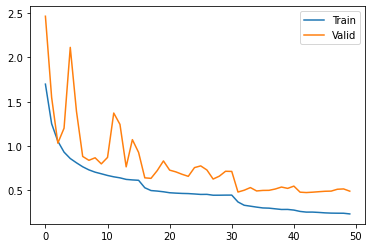

5000/5000 [==============================] - 1s 216us/step
[0.4899007513523102, 0.8988000154495239]
Epoch 1/50
352/352 [==============================] - 35s 101ms/step - loss: 1.6916 - accuracy: 0.4388 - val_loss: 4.4322 - val_accuracy: 0.2832
Epoch 2/50
352/352 [==============================] - 31s 89ms/step - loss: 1.2345 - accuracy: 0.6180 - val_loss: 1.4036 - val_accuracy: 0.5630
Epoch 3/50
352/352 [==============================] - 32s 89ms/step - loss: 1.0356 - accuracy: 0.6932 - val_loss: 1.7915 - val_accuracy: 0.5418
Epoch 4/50
352/352 [==============================] - 31s 89ms/step - loss: 0.9334 - accuracy: 0.7330 - val_loss: 1.3430 - val_accuracy: 0.6250
Epoch 5/50
352/352 [==============================] - 31s 89ms/step - loss: 0.8598 - accuracy: 0.7607 - val_loss: 2.2233 - val_accuracy: 0.4850
Epoch 6/50
352/352 [==============================] - 31s 89ms/step - loss: 0.8037 - accuracy: 0.7807 - val_loss: 1.6985 - val_accuracy: 0.5410
Epoch 7/50
352/352 [===============

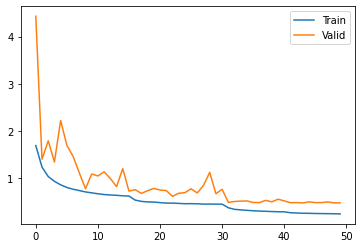

5000/5000 [==============================] - 1s 223us/step
[0.4790029389858246, 0.902999997138977]
Epoch 1/50
352/352 [==============================] - 36s 103ms/step - loss: 1.7101 - accuracy: 0.4277 - val_loss: 2.4805 - val_accuracy: 0.3512
Epoch 2/50
352/352 [==============================] - 32s 90ms/step - loss: 1.2347 - accuracy: 0.6191 - val_loss: 1.6611 - val_accuracy: 0.5420
Epoch 3/50
352/352 [==============================] - 31s 89ms/step - loss: 1.0352 - accuracy: 0.6954 - val_loss: 1.3136 - val_accuracy: 0.6220
Epoch 4/50
352/352 [==============================] - 31s 89ms/step - loss: 0.9185 - accuracy: 0.7362 - val_loss: 1.2154 - val_accuracy: 0.6642
Epoch 5/50
352/352 [==============================] - 31s 89ms/step - loss: 0.8394 - accuracy: 0.7654 - val_loss: 1.4353 - val_accuracy: 0.6218
Epoch 6/50
352/352 [==============================] - 32s 90ms/step - loss: 0.7895 - accuracy: 0.7855 - val_loss: 1.1074 - val_accuracy: 0.6866
Epoch 7/50
352/352 [================

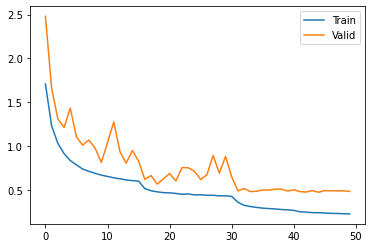

5000/5000 [==============================] - 1s 216us/step
[0.48837956686019895, 0.8962000012397766]
Epoch 1/50
352/352 [==============================] - 36s 103ms/step - loss: 1.6885 - accuracy: 0.4417 - val_loss: 1.9546 - val_accuracy: 0.4534
Epoch 2/50
352/352 [==============================] - 32s 90ms/step - loss: 1.2493 - accuracy: 0.6123 - val_loss: 1.6207 - val_accuracy: 0.5468
Epoch 3/50
352/352 [==============================] - 32s 90ms/step - loss: 1.0569 - accuracy: 0.6878 - val_loss: 1.4333 - val_accuracy: 0.6138
Epoch 4/50
352/352 [==============================] - 32s 90ms/step - loss: 0.9386 - accuracy: 0.7306 - val_loss: 2.1225 - val_accuracy: 0.5182
Epoch 5/50
352/352 [==============================] - 32s 90ms/step - loss: 0.8631 - accuracy: 0.7603 - val_loss: 1.0354 - val_accuracy: 0.7060
Epoch 6/50
352/352 [==============================] - 32s 90ms/step - loss: 0.8054 - accuracy: 0.7804 - val_loss: 0.9596 - val_accuracy: 0.7328
Epoch 7/50
352/352 [==============

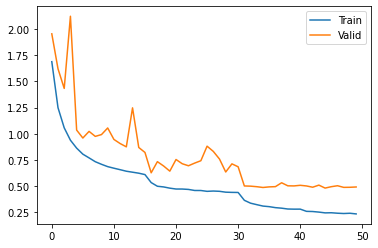

5000/5000 [==============================] - 1s 218us/step
[0.4920736852169037, 0.8988000154495239]
0.8997200012207032 0.0024152771785201574


In [0]:
results0 = np.zeros(5)

for i in range(5):
  model = ResNet()

  datagen = ImageDataGenerator(
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              )
  datagen.fit(x_trainN1)


  opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit_generator(datagen.flow(x_trainN1, y_trainN1, batch_size=128), epochs=50, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
  #history = model.fit(x_trainN1, y_trainN1, epochs = 300, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
  plot_history(history)
  res = model.evaluate(x=x_validN1, y=y_validN1, batch_size=128)
  print(res)
  results0[i] = res[1]
  model.save('/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20_mod_0_{}.hdf5'.format(i))
print(results0.mean(), np.std(results0))

## Without data augmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 34s 763us/step - loss: 1.6061 - accuracy: 0.4672 - val_loss: 1.9853 - val_accuracy: 0.4584
Epoch 2/50
45000/45000 [==============================] - 31s 689us/step - loss: 1.1418 - accuracy: 0.6520 - val_loss: 1.2221 - val_accuracy: 0.6362
Epoch 3/50
45000/45000 [==============================] - 31s 689us/step - loss: 0.9332 - accuracy: 0.7343 - val_loss: 1.2573 - val_accuracy: 0.6398
Epoch 4/50
45000/45000 [==============================] - 31s 692us/step - loss: 0.8146 - accuracy: 0.7783 - val_loss: 1.9552 - val_accuracy: 0.5588
Epoch 5/50
45000/45000 [==============================] - 31s 688us/step - loss: 0.7343 - accuracy: 0.8047 - val_loss: 1.4229 - val_accuracy: 0.6464
Epoch 6/50
45000/45000 [==============================] - 31s 688us/step - loss: 0.6804 - accuracy: 0.8272 - val_loss: 1.0267 - val_accuracy: 0.7138
Epoch 7/50
45000/45000 [==============================] -

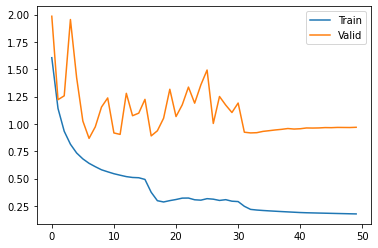

5000/5000 [==============================] - 1s 219us/step
[0.9694263667583466, 0.8450000286102295]
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 34s 763us/step - loss: 1.6561 - accuracy: 0.4436 - val_loss: 3.0419 - val_accuracy: 0.3250
Epoch 2/50
45000/45000 [==============================] - 31s 687us/step - loss: 1.1442 - accuracy: 0.6497 - val_loss: 1.4362 - val_accuracy: 0.5922
Epoch 3/50
45000/45000 [==============================] - 31s 689us/step - loss: 0.9331 - accuracy: 0.7328 - val_loss: 1.1360 - val_accuracy: 0.6638
Epoch 4/50
45000/45000 [==============================] - 31s 691us/step - loss: 0.8099 - accuracy: 0.7776 - val_loss: 1.1446 - val_accuracy: 0.6770
Epoch 5/50
45000/45000 [==============================] - 31s 687us/step - loss: 0.7356 - accuracy: 0.8070 - val_loss: 1.0270 - val_accuracy: 0.7276
Epoch 6/50
45000/45000 [==============================] - 31s 687us/step - loss: 0.6796 - accuracy: 0.8262

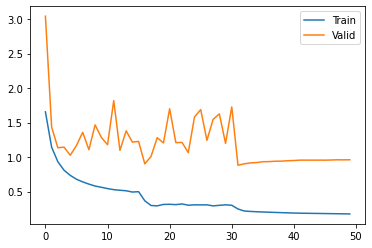

5000/5000 [==============================] - 1s 226us/step
[0.9617333738327026, 0.8446000218391418]
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 36s 794us/step - loss: 1.6005 - accuracy: 0.4773 - val_loss: 2.2293 - val_accuracy: 0.3962
Epoch 2/50
45000/45000 [==============================] - 32s 704us/step - loss: 1.1190 - accuracy: 0.6595 - val_loss: 1.5766 - val_accuracy: 0.5584
Epoch 3/50
45000/45000 [==============================] - 32s 703us/step - loss: 0.9330 - accuracy: 0.7302 - val_loss: 1.2516 - val_accuracy: 0.6394
Epoch 4/50
45000/45000 [==============================] - 32s 703us/step - loss: 0.8159 - accuracy: 0.7752 - val_loss: 1.5635 - val_accuracy: 0.5544
Epoch 5/50
45000/45000 [==============================] - 32s 702us/step - loss: 0.7492 - accuracy: 0.8012 - val_loss: 1.1074 - val_accuracy: 0.6956
Epoch 6/50
45000/45000 [==============================] - 32s 702us/step - loss: 0.6840 - accuracy: 0.8251

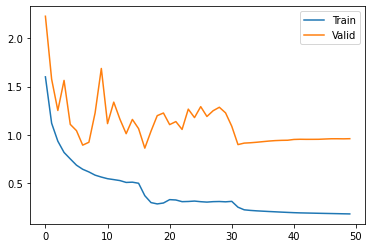

5000/5000 [==============================] - 1s 225us/step
[0.9587231199741364, 0.843999981880188]
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 35s 768us/step - loss: 1.6253 - accuracy: 0.4632 - val_loss: 1.7748 - val_accuracy: 0.4614
Epoch 2/50
45000/45000 [==============================] - 31s 693us/step - loss: 1.1311 - accuracy: 0.6573 - val_loss: 1.5348 - val_accuracy: 0.5524
Epoch 3/50
45000/45000 [==============================] - 31s 696us/step - loss: 0.9314 - accuracy: 0.7326 - val_loss: 1.4043 - val_accuracy: 0.6052
Epoch 4/50
45000/45000 [==============================] - 31s 694us/step - loss: 0.8111 - accuracy: 0.7790 - val_loss: 1.1070 - val_accuracy: 0.6842
Epoch 5/50
45000/45000 [==============================] - 31s 693us/step - loss: 0.7325 - accuracy: 0.8080 - val_loss: 1.1038 - val_accuracy: 0.6824
Epoch 6/50
45000/45000 [==============================] - 31s 693us/step - loss: 0.6720 - accuracy: 0.8306 

In [0]:
results1 = np.zeros(5)

for i in range(5):
  model = ResNet()

  opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_trainN1, y_trainN1, epochs = 50, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
  plot_history(history)
  res = model.evaluate(x=x_validN1, y=y_validN1, batch_size=128)
  print(res)
  results1[i] = res[1]
  model.save('/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20_mod_1_{}%.hdf5'.format(i))
print(results1.mean(), np.std(results1))

## Bad data augmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNet", outputs=Tensor("de...)`


Epoch 1/50
352/352 [==============================] - 37s 104ms/step - loss: 1.8789 - accuracy: 0.3585 - val_loss: 1.8771 - val_accuracy: 0.4086
Epoch 2/50
352/352 [==============================] - 32s 90ms/step - loss: 1.4756 - accuracy: 0.5202 - val_loss: 1.5854 - val_accuracy: 0.4956
Epoch 3/50
352/352 [==============================] - 32s 91ms/step - loss: 1.2951 - accuracy: 0.5899 - val_loss: 1.5917 - val_accuracy: 0.5332
Epoch 4/50
352/352 [==============================] - 32s 91ms/step - loss: 1.1918 - accuracy: 0.6282 - val_loss: 1.4914 - val_accuracy: 0.5636
Epoch 5/50
352/352 [==============================] - 32s 91ms/step - loss: 1.1135 - accuracy: 0.6592 - val_loss: 1.5034 - val_accuracy: 0.5612
Epoch 6/50
352/352 [==============================] - 32s 91ms/step - loss: 1.0528 - accuracy: 0.6818 - val_loss: 1.0877 - val_accuracy: 0.6790
Epoch 7/50
352/352 [==============================] - 32s 91ms/step - loss: 1.0026 - accuracy: 0.7010 - val_loss: 1.4119 - val_accuracy

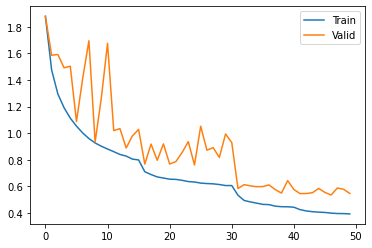

5000/5000 [==============================] - 1s 219us/step
[0.5474157535076142, 0.8676000237464905]
Epoch 1/50
352/352 [==============================] - 36s 102ms/step - loss: 1.8493 - accuracy: 0.3729 - val_loss: 3.0305 - val_accuracy: 0.2650
Epoch 2/50
352/352 [==============================] - 32s 91ms/step - loss: 1.4379 - accuracy: 0.5380 - val_loss: 2.2495 - val_accuracy: 0.3674
Epoch 3/50
352/352 [==============================] - 32s 90ms/step - loss: 1.2574 - accuracy: 0.6089 - val_loss: 1.5662 - val_accuracy: 0.5118
Epoch 4/50
352/352 [==============================] - 32s 90ms/step - loss: 1.1592 - accuracy: 0.6462 - val_loss: 1.6534 - val_accuracy: 0.5218
Epoch 5/50
352/352 [==============================] - 32s 90ms/step - loss: 1.0750 - accuracy: 0.6748 - val_loss: 1.3986 - val_accuracy: 0.5798
Epoch 6/50
352/352 [==============================] - 32s 90ms/step - loss: 1.0208 - accuracy: 0.6979 - val_loss: 1.1513 - val_accuracy: 0.6594
Epoch 7/50
352/352 [===============

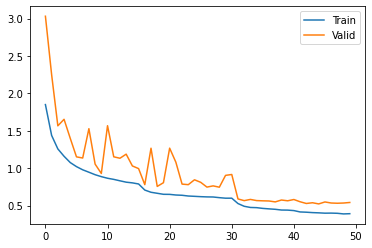

5000/5000 [==============================] - 1s 221us/step
[0.5417950231075287, 0.868399977684021]
Epoch 1/50
352/352 [==============================] - 36s 102ms/step - loss: 1.8714 - accuracy: 0.3576 - val_loss: 2.6541 - val_accuracy: 0.2870
Epoch 2/50
352/352 [==============================] - 32s 91ms/step - loss: 1.4737 - accuracy: 0.5183 - val_loss: 3.3773 - val_accuracy: 0.3408
Epoch 3/50
352/352 [==============================] - 32s 91ms/step - loss: 1.2774 - accuracy: 0.5972 - val_loss: 1.6688 - val_accuracy: 0.5326
Epoch 4/50
352/352 [==============================] - 32s 90ms/step - loss: 1.1706 - accuracy: 0.6376 - val_loss: 1.5591 - val_accuracy: 0.5212
Epoch 5/50
352/352 [==============================] - 32s 91ms/step - loss: 1.1045 - accuracy: 0.6622 - val_loss: 1.2307 - val_accuracy: 0.6284
Epoch 6/50
352/352 [==============================] - 33s 93ms/step - loss: 1.0412 - accuracy: 0.6884 - val_loss: 1.3865 - val_accuracy: 0.5862
Epoch 7/50
352/352 [================

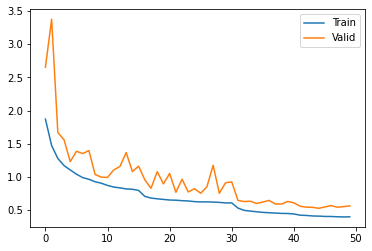

5000/5000 [==============================] - 1s 220us/step
[0.5645955599069595, 0.8619999885559082]
Epoch 1/50
352/352 [==============================] - 36s 103ms/step - loss: 1.8248 - accuracy: 0.3745 - val_loss: 4.5644 - val_accuracy: 0.2216
Epoch 2/50
352/352 [==============================] - 32s 91ms/step - loss: 1.4390 - accuracy: 0.5365 - val_loss: 1.8843 - val_accuracy: 0.4204
Epoch 3/50
352/352 [==============================] - 32s 92ms/step - loss: 1.2613 - accuracy: 0.6038 - val_loss: 3.0983 - val_accuracy: 0.4000
Epoch 4/50
352/352 [==============================] - 32s 91ms/step - loss: 1.1443 - accuracy: 0.6467 - val_loss: 1.5133 - val_accuracy: 0.5620
Epoch 5/50
352/352 [==============================] - 32s 91ms/step - loss: 1.0715 - accuracy: 0.6782 - val_loss: 1.2709 - val_accuracy: 0.6200
Epoch 6/50
352/352 [==============================] - 32s 91ms/step - loss: 1.0099 - accuracy: 0.7004 - val_loss: 1.1523 - val_accuracy: 0.6526
Epoch 7/50
352/352 [===============

In [0]:
results2 = np.zeros(5)

for i in range(5):
  model = ResNet()

  datagen = ImageDataGenerator(
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              vertical_flip=True,
                              )
  datagen.fit(x_trainN1)


  opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit_generator(datagen.flow(x_trainN1, y_trainN1, batch_size=128), epochs=50, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
  #history = model.fit(x_trainN1, y_trainN1, epochs = 300, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
  plot_history(history)
  res = model.evaluate(x=x_validN1, y=y_validN1, batch_size=128)
  print(res)
  results2[i] = res[1]
  model.save('/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20_mod_2_{}.hdf5'.format(i))
print(results2.mean(), np.std(results2))

In [0]:
print(results2.mean(), np.std(results2))

0.8690400004386902 0.004334795115587272


In [0]:
results2

array([0.86760002, 0.86839998, 0.86199999, 0.87400001, 0.8732    ])

In [0]:
print(results1.mean(), np.std(results1))

0.8466400027275085 0.0026755090393228266


In [0]:
results1

array([0.84500003, 0.84460002, 0.84399998, 0.8488    , 0.85079998])

In [0]:
print(results0.mean(), np.std(results0))

0.8997200012207032 0.0024152771785201574


In [0]:
results0

array([0.90179998, 0.89880002, 0.903     , 0.8962    , 0.89880002])

# Resnet Dropout

In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 50:
      return 0.01
  if epoch > 25:
      return 0.05
  return 0.1

lrschedulerDropout = LearningRateScheduler(lfScheduleF, verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="ResNetDropout", outputs=Tensor("de...)`


Epoch 1/70
352/352 [==============================] - 37s 104ms/step - loss: 1.8109 - accuracy: 0.3780 - val_loss: 2.0279 - val_accuracy: 0.4092
Epoch 2/70
352/352 [==============================] - 32s 92ms/step - loss: 1.3751 - accuracy: 0.5572 - val_loss: 1.8276 - val_accuracy: 0.4612
Epoch 3/70
352/352 [==============================] - 32s 92ms/step - loss: 1.1693 - accuracy: 0.6417 - val_loss: 2.1644 - val_accuracy: 0.4448
Epoch 4/70
352/352 [==============================] - 32s 92ms/step - loss: 1.0457 - accuracy: 0.6894 - val_loss: 1.1467 - val_accuracy: 0.6710
Epoch 5/70
352/352 [==============================] - 32s 92ms/step - loss: 0.9629 - accuracy: 0.7216 - val_loss: 1.0594 - val_accuracy: 0.6938
Epoch 6/70
352/352 [==============================] - 32s 92ms/step - loss: 0.9025 - accuracy: 0.7449 - val_loss: 1.1492 - val_accuracy: 0.6682
Epoch 7/70
352/352 [==============================] - 32s 92ms/step - loss: 0.8535 - accuracy: 0.7620 - val_loss: 0.9069 - val_accuracy

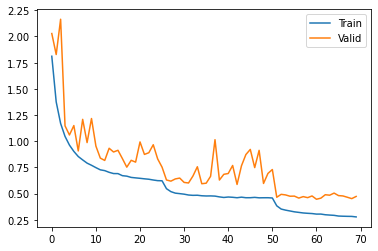

5000/5000 [==============================] - 1s 215us/step
[0.47242559127807615, 0.8971999883651733]
Epoch 1/70
352/352 [==============================] - 35s 101ms/step - loss: 1.7894 - accuracy: 0.3907 - val_loss: 2.1335 - val_accuracy: 0.4132
Epoch 2/70
352/352 [==============================] - 31s 89ms/step - loss: 1.3653 - accuracy: 0.5667 - val_loss: 2.0659 - val_accuracy: 0.4206
Epoch 3/70
352/352 [==============================] - 32s 90ms/step - loss: 1.1782 - accuracy: 0.6357 - val_loss: 1.5482 - val_accuracy: 0.5814
Epoch 4/70
352/352 [==============================] - 31s 89ms/step - loss: 1.0565 - accuracy: 0.6866 - val_loss: 1.0735 - val_accuracy: 0.6802
Epoch 5/70
352/352 [==============================] - 31s 89ms/step - loss: 0.9678 - accuracy: 0.7193 - val_loss: 2.1571 - val_accuracy: 0.5264
Epoch 6/70
352/352 [==============================] - 32s 90ms/step - loss: 0.9050 - accuracy: 0.7427 - val_loss: 1.4373 - val_accuracy: 0.5970
Epoch 7/70
352/352 [==============

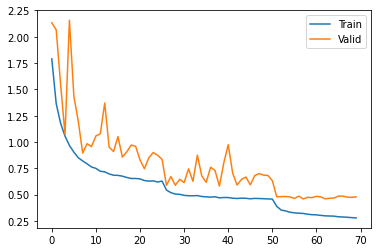

5000/5000 [==============================] - 1s 214us/step
[0.48001402745246885, 0.8992000222206116]
Epoch 1/70
352/352 [==============================] - 35s 101ms/step - loss: 1.7973 - accuracy: 0.3772 - val_loss: 4.1383 - val_accuracy: 0.2094
Epoch 2/70
352/352 [==============================] - 31s 89ms/step - loss: 1.3755 - accuracy: 0.5604 - val_loss: 1.4159 - val_accuracy: 0.5554
Epoch 3/70
352/352 [==============================] - 31s 89ms/step - loss: 1.1777 - accuracy: 0.6345 - val_loss: 1.4465 - val_accuracy: 0.5666
Epoch 4/70
352/352 [==============================] - 32s 90ms/step - loss: 1.0586 - accuracy: 0.6838 - val_loss: 1.3752 - val_accuracy: 0.6078
Epoch 5/70
352/352 [==============================] - 32s 90ms/step - loss: 0.9693 - accuracy: 0.7188 - val_loss: 1.3139 - val_accuracy: 0.6270
Epoch 6/70
352/352 [==============================] - 31s 89ms/step - loss: 0.9138 - accuracy: 0.7414 - val_loss: 1.1624 - val_accuracy: 0.6562
Epoch 7/70
352/352 [==============

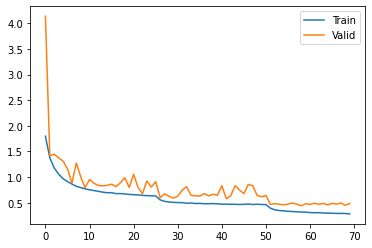

5000/5000 [==============================] - 1s 214us/step
[0.48679867210388184, 0.8978000283241272]


In [0]:
results3 = np.zeros(5)
results3[0] = 0.8880000114440918
for i in range(1,4):
  model = ResNetDropout()

  datagen = ImageDataGenerator(
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              )
  datagen.fit(x_trainN1)


  opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit_generator(datagen.flow(x_trainN1, y_trainN1, batch_size=128), epochs=70, validation_data=(x_validN1, y_validN1), callbacks=[lrschedulerDropout])
  #history = model.fit(x_trainN1, y_trainN1, epochs = 300, batch_size = 128, validation_data=(x_validN1, y_validN1), callbacks=[lrscheduler])
  plot_history(history)
  res = model.evaluate(x=x_validN1, y=y_validN1, batch_size=128)
  print(res)
  results3[i] = res[1]
  model.save('/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20_mod_3_{}.hdf5'.format(i))


In [0]:
#[0.524532604598999, 0.8880000114440918]
model.save('/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20_mod_3_{}.hdf5'.format(i))
print(results3.mean(), np.std(results3))

In [0]:
results3 = np.array([0.88800001, 0.89719999, 0.89920002, 0.89780003])

In [0]:
print(results3.mean(), np.std(results3))

0.8955500125 0.004418995841842221
